In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0
from scipy.special import i1
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from cmath import rect
from scipy.signal import savgol_filter
import seaborn as sns
from scipy.ndimage import convolve1d
from matplotlib import animation
from matplotlib import rc as matrc
from matplotlib import rcParams
from IPython.display import HTML
from scipy.optimize import curve_fit
import custom_plot as cplt

matrc('animation', html='jshtml', embed_limit=20971520*2)

In [5]:
def set_style(tex=False, box=False, ymargin=0.0, xmargin=0.0):
    nice_fonts = {
            # Use LaTeX to write all text
            "text.usetex": tex,
            "font.family": "serif",
            "axes.labelsize": 11,
            "font.size": 9,
            "legend.fontsize": 8,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
    }
    rcParams.update(nice_fonts)
    rcParams['axes.xmargin'] = xmargin
    rcParams['axes.ymargin'] = ymargin
    rcParams["axes.spines.right"] = box
    rcParams["axes.spines.top"] = box

def M(mu, kappa):
    return lambda x: np.exp(kappa*np.cos(x-mu))/(2*np.pi*i0(kappa))

def Gaussian(mu, sigma, A=None):
    if A is None:
        return lambda x: 1 / np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mu)**2/(2*sigma**2))
    else:
        return lambda x: A * np.exp(-(x-mu)**2/(2*sigma**2))

def norm(f, kappa, beta):
    """
    Firing rate (normalization) in the continuous theta case and 
    where u(theta) follows von Mises distribution
    """
    c = 1 + beta/(2*np.pi) * i0(2*kappa)/i0(kappa)**2
    return lambda x: f(x)**2 / c

def mean(data, axis=0, weights=None):
    """
    Mean of data. Can calculate weighted mean, where each datum is weighted
    by its corresponding entry in WEIGHTS.
    """
    data = np.array(data)
    return np.average(data, axis=axis, weights=weights)

def stddev(data, axis=0, ddof=1, weights=None, delta=None):
    """
    Calculates standard deviation of data. ddof is the degrees of freedom, and
    is usually 1.
    """
    data = np.array(data)
    if weights is not None:
        V = sum(weights)
        avg = mean(data, axis=axis, weights=weights)
        variance = mean((data-avg)**2, axis=axis, weights=weights) * V / (V - ddof)
        dev = np.sqrt(variance)
    else:
        dev = np.std(data, axis=axis, ddof=ddof)
    if delta is None:
        return dev
    delta = np.array(delta)
    return np.sqrt(dev**2 + delta**2)

def stderr(data, axis=0, ddof=1, weights=None, delta=None):
    """
    Calculates standard error of data.
    """
    data = np.array(data)
    if delta is None:
        return stddev(data, axis=axis, ddof=ddof, weights=weights)/np.sqrt(len(data))
    delta = np.array(delta)
    return np.sqrt(sum(stddev(data, axis=axis, ddof=ddof, weights=weights, delta=delta)**2))/len(data)

def perm_mat(size, k):
    """
    Returns a permutation matrix that shifts element
    to the right by k along the first axis
    """
    a = np.zeros(size)
    for i, row in enumerate(a):
        index = (i+k) % len(a)
        row[index] = 1
    return a

def my_reset(*varnames):
    """
    Free up all variables except varnames, which are what you want to keep.
    Used when memory is low or something. Example use:
    my_reset('wc10', 'wc20')
    which will free up all variables but wc10 and wc20.
    """
    globals_ = globals()
    to_save = {v: globals_[v] for v in varnames}
    to_save['my_reset'] = my_reset
    del globals_
    get_ipython().magic("reset")
    globals().update(to_save)
    
def calc_corr(a, b):
    """
    Calculates correlation between two vectors. Can call np.corrcoef(a, b)[:N,N:] 
    as well, where N = len(a) = len(b)
    """
    a_bar = mean(a)
    b_bar = mean(b)
    return np.dot(a-a_bar, b-b_bar)/(np.linalg.norm(a-a_bar)*np.linalg.norm(b-b_bar))

In [6]:
def r(ui, u, omega):
    """
    Firing rate (normalization) of ui in the discrete theta case,
    as a function of all neurons' u, and parameter omega.
    """
    zeros = np.zeros(len(u))
    return np.maximum(ui, 0)**2.0 / (1 + omega * np.sum(np.maximum(u, zeros)**2.0))

def init_weights(N, mu, sigma, thetas):
    """
    Initialize N*N feedforward weights somewhat randomly. For each neuron, assign
    a random strength parameter distributed as a log-normal distribution
    with mean MU and standard deviation SIGMA. Each neuron's feedforward connection
    is a von Mises distribution with concentration 2, scaled by its strength, and with
    a Gaussian white noise with variance = 0.5 * mean. The center of the feedforward 
    projection is random.
    """
    strengths = np.random.lognormal(mean=mu, sigma=sigma, size=N) # neuron strengths
    w = np.zeros((N,N)) # feedforward weights. row is input neuron.
    for i, theta in enumerate(thetas):
        distrb = lambda thetas: strengths[i] * M(theta, 2)(thetas) # von Mises feedforward weights scaled by strength
        # add Gaussian noise and force weights to be non-negative
        w[i] = np.maximum(distrb(thetas) + np.random.normal(size=N, scale=np.sqrt(0.5*distrb(thetas))), np.zeros(N))
    np.random.shuffle(w) # shuffle by row (input neurons), so connectivitiy is random.
    return w.T.flatten() # transpose weight matrix and flatten it

def Newton(f, y0, ts, save_ts, progress=True):
    """
    Simulate the differential equation dydt = f(y) with Newton's method.
    Initialize y = y0. ts is an array of the simulation timesteps, and
    save_ts is an array of the timesteps at which y should be copied
    to the output results ys. save_ts should be evenly spaced
    """
    ys = np.zeros((len(save_ts), len(y0)))
    r1_in_save = np.zeros((len(save_ts), N))
    r2_in_save = np.zeros((len(save_ts), N))
    y = y0
    dt = ts[1] - ts[0]
    k = -1
    # assume save_ts is evenly spaced, then skip is # of simulation timesteps skipped between copying y to the results
    skip = int(round(len(ts)/(len(save_ts)-1)))
    # save all rc and ro values
    all_rc = np.zeros((len(ts)+1,N))
    all_ro = np.zeros((len(ts)+1,N))
    for i, t in enumerate(ts):
        if progress is True:
            print("Iteration: ", i)
        if i % skip == 0:
            # copy simulation data to outputs
            k += 1
            ys[k] = y
            r1_in_save[k] = r1_in[i]
            r2_in_save[k] = r2_in[i]
        uc, uo = y[:N], y[N:2*N]
        all_rc[i], all_ro[i] = r(uc, uc, omega), r(uo, uo, omega)
        
        y = y + dt*f(t, y, i, all_rc)
        
        # Set excitatory synapses to non-negative, inhibitory to non-positive
        w, thc, tho = y[2*N:-2*N], y[-2*N:-N], y[-N:]
        assert len(w) == 4*N*N
        wpos, wneg = w[:3*N*N], w[3*N*N:]
        # both excitatory and inhibitory connections are rectified positively, as negative sign
        # is added to inhibitory input in the dynamical equations.
        wpos, wneg = np.maximum(wpos, np.zeros(3*N*N)), np.maximum(wneg, np.zeros(N*N))
        w = np.concatenate((wpos, wneg))
        y[2*N:-2*N] = w
        
    ys[-1] = y
    uc, uo = y[:N], y[N:2*N]
    all_rc[-1], all_ro[-1] = r(uc, uc, omega), r(uo, uo, omega)
    return (save_ts, ys, r1_in_save, r2_in_save, [all_rc, all_ro])

## Learning the feedforward weights

In [7]:
# Parameters
N = 180 # Number of neurons per module
a1_in = 1.5 # Input concentration of modality 1
a2_in = 1.5 # Input concentration of modality 2
a_rc = 3.0 # Recurrent connections concentration
omega = 1.6e-2 # constant controlling strength of divisive normalization
tau_stim = 0.1 # time per stimulus
tau = 0.01 # time constant of leaky integrator
delta_t = 0.1 * tau # simulation timestep
tau_we = 10.0 # time constant of synaptic weight change of excitatory neurons
tau_wi = 10.0 # time constant of synaptic weight change of inhibitory neurons
tau_b = 5.0 # time constant of threshold change
delay = 0.02 # delay of signal from C to O
T = 120.0 # simulation time
save_interval = 300 # save simulation state every SAVE_INTERVAL steps. Should be a number that divides T/delta_t.
F = 0.5 # Fano factor, controls variance of firing rate
R1 = 1.0 # Maximum mean firing rate for modality 1
R2 = 1.0 # Maximum mean firing rate for modality 2
Ibc = -1.2 # constant background input to congruent neurons. Chosen by trial-and-error such that congruent neuron synaptic input has approximately 0 DC offset.
Ibo = 0.15 # contsant background input to opposite neurons
alpha = 15.0 # Controls strength of connections, the larger the weaker.

thetas = np.linspace(-np.pi, np.pi, num=N, endpoint=False) # depends on N
n = int(round(T / delta_t)) # Number of timesteps # depends on T and delta_t
ts = np.linspace(0.0, T, num=n, endpoint=False) # depends on n
save_ts = np.linspace(0.0, T, num=int(n/save_interval)+1) # depends on ts
delay_n = int(round(delay/delta_t)) # Number of timesteps to delay for

N_repeats = int(round(tau_stim / delta_t)) # number of simulation steps for each stimulus
N_stim = int(round(n/N_repeats)) # number of stimuli

# Convert stimulus location to firing rate
r1_in = np.loadtxt("Initialization/firing_rate_1.csv")
r2_in = np.loadtxt("Initialization/firing_rate_2.csv")

# Set up recurrent connections
rho = N/(2*np.pi)
J_crit2 = lambda a: np.sqrt(1/(rho*i0(a)) * 8*np.pi*omega*i0(a/2)**2)
W = lambda J, a: lambda theta1, theta2: J / (2*np.pi * i0(a)) * np.exp(a*np.cos(theta1 - theta2))
wro = W(0.5*J_crit2(a_rc), a_rc)(thetas, 0)
wrc = W(0.5*J_crit2(a_rc), a_rc)(thetas, 0)

# Initialize model
# Initialize weights
w0 = np.loadtxt("Initialization/initial_weights.csv")
u0 = np.zeros(2*N)
ubc0, ubo0 = np.zeros(N), np.zeros(N)
y0 = np.concatenate((u0, w0, ubc0, ubo0))

def dydt(t, y, i, all_rc):
    l, l2 = 2*N, -2*N
    u, w, ubs = y[:l], y[l:l2], y[l2:]
    l = N
    ubc, ubo = ubs[:l], ubs[l:]
    uc, uo = u[:l], u[l:]
    rc, ro = r(uc, uc, omega), r(uo, uo, omega)
    l = N*N
    wc1, wc2, wo1, wo2 = [np.reshape(w[j*l:(j+1)*l], (N,N)) for j in range(4)]
    j = max(i-delay_n, 0)
    dubcdt = np.zeros(N)
    dubodt = np.zeros(N)
    ducdt = 1/tau * (-uc + Ibc + convolve1d(rc, wrc, mode="wrap") + np.dot(wc1, r1_in[i]) + np.dot(wc2, r2_in[i]))
    duodt = 1/tau * (-uo + Ibo + convolve1d(ro, wro, mode="wrap") + np.dot(wo1, r1_in[i]) - np.dot(wo2, all_rc[j]))
    dwc1dt = 1/tau_we * (np.outer(rc, r1_in[i]) - np.multiply(rc, alpha*wc1.T).T)
    dwc2dt = 1/tau_we * (np.outer(rc, r2_in[i]) - np.multiply(rc, alpha*wc2.T).T)
    dwo1dt = 1/tau_we * (np.outer(ro, r1_in[i]) - np.multiply(ro, alpha*wo1.T).T)
    dwo2dt = 1/tau_wi * (np.outer(ro, all_rc[j]) - np.multiply(ro, alpha*wo2.T).T)

    return np.concatenate((ducdt, duodt, dwc1dt.flatten(), dwc2dt.flatten(), dwo1dt.flatten(), dwo2dt.flatten(), dubcdt, dubodt))

t, ys, r1_in_save, r2_in_save, all_rs = Newton(dydt, y0, ts, save_ts, progress=False)

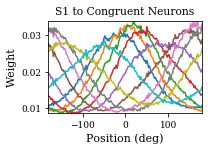

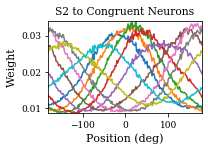

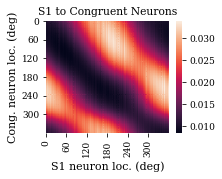

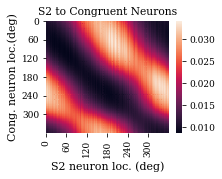

In [8]:
set_style(box=True) # nice looking plot style
y = ys[-1]
l = 2*N
u, w = y[:l], y[l:]
l = N
uc, uo = u[:l], u[l:]
# rc, ro = [r(uci, uc, omega) for uci in uc], [r(uoi, uo, omega) for uoi in uo]
l = N*N
wc1, wc2, wo1, wo2 = [np.reshape(w[i*l:(i+1)*l], (N,N)) for i in range(4)]

### Plot 10 congruent neuron feedforward weights ###

plt.figure(figsize=cplt.set_size("nips", fraction=0.5))
plt.title("S1 to Congruent Neurons")
for i in range(0,180,18):
    plt.plot(np.rad2deg(thetas), wc1[i])
plt.xlabel("Position (deg)")
plt.ylabel("Weight")
# cplt.savefig("Manuscript/Figures/wc1_RF.pdf")
plt.show()

plt.figure(figsize=cplt.set_size("nips", fraction=0.5))
plt.title("S2 to Congruent Neurons")
for i in range(0, 180, 18):
    plt.plot(np.rad2deg(thetas), wc2[i])
plt.xlabel("Position (deg)")
plt.ylabel("Weight")
# cplt.savefig("Manuscript/Figures/wc2_RF.pdf")
plt.show()

### Plot all congruent neuron weights ###

plt.figure(figsize=cplt.set_size("nips", fraction=0.5, ratio=0.75))
sns.heatmap(wc1)
plt.xticks(np.arange(0, 180, 30), np.arange(0, 360, 60))
plt.yticks(np.arange(0, 180, 30), np.arange(0, 360, 60))
plt.title("S1 to Congruent Neurons")
plt.ylabel("Cong. neuron loc. (deg)")
plt.xlabel("S1 neuron loc. (deg)")
# plt.savefig("Manuscript/Figures/wc1_matrix.png")
# cplt.savefig("Manuscript/Figures/wc1_matrix.pdf")
plt.show()

plt.figure(figsize=cplt.set_size("nips", fraction=0.5, ratio=0.75))
sns.heatmap(wc2)
plt.xticks(np.arange(0, 180, 30), np.arange(0, 360, 60))
plt.yticks(np.arange(0, 180, 30), np.arange(0, 360, 60))
plt.title("S2 to Congruent Neurons")
plt.ylabel("Cong. neuron loc.(deg)")
plt.xlabel("S2 neuron loc. (deg)")
# plt.savefig("Manuscript/Figures/wc2_matrix.png")
# cplt.savefig("Manuscript/Figures/wc2_matrix.pdf")
plt.show()

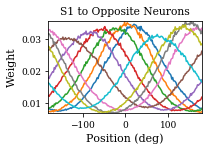

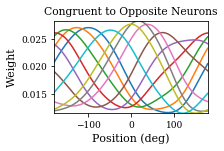

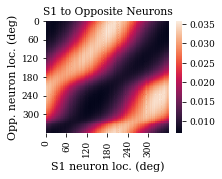

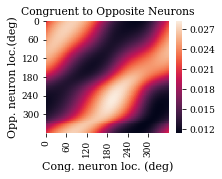

In [9]:
set_style(box=True)
y = ys[-1]
l, l2 = 2*N, -2*N
u, w = y[:l], y[l:l2]
l = N
uc, uo = u[:l], u[l:]
# rc, ro = [r(uci, uc, omega) for uci in uc], [r(uoi, uo, omega) for uoi in uo]
l = N*N
wc1, wc2, wo1, wo2 = [np.reshape(w[i*l:(i+1)*l], (N,N)) for i in range(4)]

### Plot 10 opposite neuron feedforward weights ###

plt.figure(figsize=cplt.set_size("nips", fraction=0.5))
plt.title("S1 to Opposite Neurons")
for i in range(0,180,18):
    plt.plot(np.rad2deg(thetas), wo1[i])
plt.xlabel("Position (deg)")
plt.ylabel("Weight")
# cplt.savefig("Manuscript/Figures/wo1_RF.pdf")
plt.show()


plt.figure(figsize=cplt.set_size("nips", fraction=0.5))
plt.title("Congruent to Opposite Neurons")
for i in range(0,180,18):
    plt.plot(np.rad2deg(thetas), wo2[i])
plt.xlabel("Position (deg)")
plt.ylabel("Weight")
# cplt.savefig("Manuscript/Figures/wo2_RF.pdf")
plt.show()

### Plot all opposite neuron weights ###

plt.figure(figsize=cplt.set_size("nips", fraction=0.5, ratio=0.75))
sns.heatmap(wo1)
plt.xticks(np.arange(0, 180, 30), np.arange(0, 360, 60))
plt.yticks(np.arange(0, 180, 30), np.arange(0, 360, 60))
plt.title("S1 to Opposite Neurons")
plt.ylabel("Opp. neuron loc. (deg)")
plt.xlabel("S1 neuron loc. (deg)")
# plt.savefig("Manuscript/Figures/wo1_matrix.png")
# cplt.savefig("Manuscript/Figures/wo1_matrix.pdf")
plt.show()

plt.figure(figsize=cplt.set_size("nips", fraction=0.5, ratio=0.75))
sns.heatmap(wo2)
plt.xticks(np.arange(0, 180, 30), np.arange(0, 360, 60))
plt.yticks(np.arange(0, 180, 30), np.arange(0, 360, 60))
plt.title("Congruent to Opposite Neurons")
plt.ylabel("Opp. neuron loc.(deg)")
plt.xlabel("Cong. neuron loc. (deg)")
# plt.savefig("Manuscript/Figures/wo2_matrix.png")
# cplt.savefig("Manuscript/Figures/wo2_matrix.pdf")
plt.show()

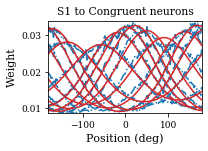

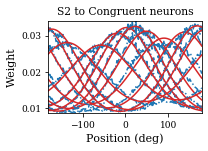

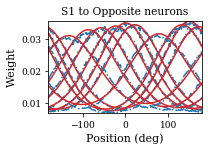

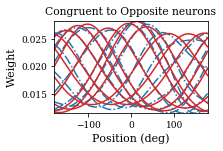

In [10]:
def norm_tc(ws, axis=1, extra=True):
    """
    Normalizes a feedforward weight matrix WS by row.
    If only normalizing feeforward weights to one neuron,
    use axis=0.
    """
    integrals = np.sum(ws, axis=axis) * (2*np.pi / N)
    if extra:
        return (ws/integrals, integrals)
    return ws / integrals

def fit(nws, thetas=thetas):
    """
    Fits a von Mises distribution to the normalized weight matrix NWS.
    """
    func = lambda theta, mu, kappa: M(mu, kappa)(theta)
    popt, pcov = curve_fit(func, thetas, nws, bounds=([-np.pi, 0], [np.pi, np.inf]))
    perr = np.sqrt(np.diag(pcov))
    return (M(*popt), popt, perr)

y = ys[-1]
l = 2*N
u, w = y[:l], y[l:]
l = N*N
rc = r(uc, uc, omega)
wc1, wc2, wo1, wo2 = [np.reshape(w[i*l:(i+1)*l], (N,N)) for i in range(4)]
thetas = np.linspace(-np.pi, np.pi, num=N, endpoint=False)

(nwc1, iwc1), (nwc2, iwc2), (nwo1, iwo1), (nwo2, iwo2) = norm_tc(wc1), norm_tc(wc2), norm_tc(wo1), norm_tc(wo2)
all_rc, all_ro = all_rs
src, sro = all_rc[-180:], all_ro[-180:]
(nrc, irc), (nro, iro) = norm_tc(src), norm_tc(sro)

### Plot feedforward weights and fit it with von Mises distribution ###

set_style(box=True)
plt.figure(figsize=cplt.set_size("nips", fraction=0.5))
plt.title("S1 to Congruent neurons")
for i in range(0,180,18):
    plt.plot(np.rad2deg(thetas), wc1[i], color="tab:blue", linestyle='-.')
    func, popt, perr = fit(nwc1[i])
    plt.plot(np.rad2deg(thetas), func(thetas)*iwc1, color="tab:red")
plt.xlabel("Position (deg)")
plt.ylabel("Weight")
# cplt.savefig("Manuscript/Figures/sample_fitting_wc1_with_vM.pdf")
plt.show()

plt.figure(figsize=cplt.set_size("nips", fraction=0.5))
plt.title("S2 to Congruent neurons")
for i in range(0,180,18):
    plt.plot(np.rad2deg(thetas), wc2[i], color="tab:blue", linestyle='-.')
    func, popt, perr = fit(nwc2[i])
    plt.plot(np.rad2deg(thetas), func(thetas)*iwc2, color="tab:red")
plt.xlabel("Position (deg)")
plt.ylabel("Weight")
# cplt.savefig("Manuscript/Figures/sample_fitting_wc2_with_vM.pdf")
plt.show()

plt.figure(figsize=cplt.set_size("nips", fraction=0.5))
plt.title("S1 to Opposite neurons")
for i in range(0,180,18):
    plt.plot(np.rad2deg(thetas), wo1[i], color="tab:blue", linestyle='-.')
    func, popt, perr = fit(nwo1[i])
    plt.plot(np.rad2deg(thetas), func(thetas)*iwo1, color="tab:red")
plt.xlabel("Position (deg)")
plt.ylabel("Weight")
# cplt.savefig("Manuscript/Figures/sample_fitting_wo1_with_vM.pdf")
plt.show()

plt.figure(figsize=cplt.set_size("nips", fraction=0.5))
plt.title("Congruent to Opposite neurons")
for i in range(0,180,18):
    plt.plot(np.rad2deg(thetas), wo2[i], color="tab:blue", linestyle='-.')
    func, popt, perr = fit(nwo2[i])
    plt.plot(np.rad2deg(thetas), func(thetas)*iwo2, color="tab:red")
plt.xlabel("Position (deg)")
plt.ylabel("Weight")
# cplt.savefig("Manuscript/Figures/sample_fitting_wo2_with_vM.pdf")
plt.show()

## Tuning curve

In [11]:
y = ys[-1]
l, l2 = 2*N, -2*N
u, w, ubs = y[:l], y[l:l2], y[l2:]
l = N*N
wc1f, wc2f, wo1f, wo2f = [np.reshape(w[i*l:(i+1)*l], (N,N)) for i in range(4)]
ubcf, ubof = ubs[:N], ubs[N:]

In [12]:
def simulate(R1, a1_in, R2, a2_in):
    """
    Run the trained network with the given S1 and S2 inputs.
    Returns the congruent and opposite neuron responses over time.
    """
    # Parameters
    N = 180 # Number of neurons per module
    a_rc = 3.0 # Recurrent connections concentration
    omega = 1.6e-2
    tau_stim = 0.1 # time per stimulus
    tau = 0.01 # time constant of leaky integrator
    delta_t = 0.05 * tau # simulation timestep
    tau_we = 10.0 # time constant of synaptic weight change of excitatory neurons
    tau_wi = 10.0 # time constant of synaptic weight change of inhibitory neurons
    tau_b = 5.0 # time constant of threshold change
    delay = 0.02 # delay of signal from C to O
    T = 18.0 # simulation time
    save_interval = 400 # save simulation state every SAVE_INTERVAL steps. Should be a number that divides T/delta_t.
    F = 0.5 # Fano factor, controls variance of firing rate
    Ibc = -1.2
    Ibo = 0.15
    alpha = 15.0 # Controls strength of anti-hebbian connections, the larger the weaker.

    thetas = np.linspace(-np.pi, np.pi, num=N, endpoint=False) # depends on N
    n = int(round(T / delta_t)) # Number of timesteps # depends on T and delta_t
    ts = np.linspace(0.0, T, num=n, endpoint=False) # depends on n
    save_ts = np.linspace(0.0, T, num=int(n/save_interval)+1) # depends on ts
    delay_n = int(round(delay/delta_t)) # Number of timesteps to delay for

    N_repeats = int(round(tau_stim / delta_t)) # number of simulation steps for each stimulus
    N_stim = int(round(n/N_repeats)) # number of stimuli

    # Generate stimulus location for modality 1
    # Note that here we run the whole simulation twice and only record the results from the second run.
    # This is not very useful right now, but might be more useful when background input can change,
    # since the first run could be used to stabilize the background input.
    s_ = np.linspace(-180.0, 180.0, num=int(N_stim/2), endpoint=False)
    s_ = np.concatenate((s_, s_))
    s1 = np.repeat(np.deg2rad(s_), N_repeats)

    # Generate stimulus location for modality 2
    s2 = np.repeat(np.deg2rad(s_), N_repeats)

    # Convert stimulus location to firing rate
    const = np.exp(-3.0)*i0(3.0)*2*np.pi
    baseline = lambda R, a: (1-R) * const / (2*np.pi)
    lamb = lambda s, R, a: lambda theta_j: R*const/(2*np.pi*i0(a))*np.exp(a*np.cos(s-theta_j)) + baseline(R, a)
    r_in = lambda s, R, a: np.maximum(lamb(s,R,a)(thetas) + np.sqrt(F*lamb(s,R,a)(thetas))*np.random.normal(size=N), np.zeros(len(thetas)))
    r1_in = np.array([r_in(s1[i], R1, a1_in) for i in range(n)] + [np.zeros(N)])
    r2_in = np.array([r_in(s2[i], R2, a2_in) for i in range(n)] + [np.zeros(N)])

    # Set up recurrent connections
    rho = N/(2*np.pi)
    J_crit2 = lambda a: np.sqrt(1/(rho*i0(a)) * 8*np.pi*omega*i0(a/2)**2)
    W = lambda J, a: lambda theta1, theta2: J / (2*np.pi * i0(a)) * np.exp(a*np.cos(theta1 - theta2))
    wro = W(0.5*J_crit2(a_rc), a_rc)(thetas, 0)
    wrc = W(0.5*J_crit2(a_rc), a_rc)(thetas, 0)

    # Initialize model
    w0 = np.concatenate((wc1f.flatten(), wc2f.flatten(), wo1f.flatten(), wo2f.flatten()))
    u0 = np.zeros(2*N)
    ubc0, ubo0 = ubcf, ubof
    y0 = np.concatenate((u0, w0, ubc0, ubo0))
    
    def dydt(t, y, i, all_rc):
        l, l2 = 2*N, -2*N
        u, w, ubs = y[:l], y[l:l2], y[l2:]
        l = N
        ubc, ubo = ubs[:l], ubs[l:]
        uc, uo = u[:l], u[l:]
        rc, ro = r(uc, uc, omega), r(uo, uo, omega)
        l = N*N
        wc1, wc2, wo1, wo2 = [np.reshape(w[j*l:(j+1)*l], (N,N)) for j in range(4)]
        j = max(i-delay_n, 0)
        dubcdt = np.zeros(N)
        dubodt = np.zeros(N)
        ducdt = 1/tau * (-uc + Ibc + convolve1d(rc, wrc, mode="wrap") + np.dot(wc1, r1_in[i]) + np.dot(wc2, r2_in[i]))
        duodt = 1/tau * (-uo + Ibo + convolve1d(ro, wro, mode="wrap") + np.dot(wo1, r1_in[i]) - np.dot(wo2, all_rc[j]))
        dwc1dt = np.zeros(N*N)
        dwc2dt = np.zeros(N*N)
        dwo1dt = np.zeros(N*N)
        dwo2dt = np.zeros(N*N)

        return np.concatenate((ducdt, duodt, dwc1dt.flatten(), dwc2dt.flatten(), dwo1dt.flatten(), dwo2dt.flatten(), dubcdt, dubodt))

    t, ys, r1_in_save, r2_in_save, all_rs = Newton(dydt, y0, ts, save_ts, progress=False)

    N_cut = int(len(all_rs[0])/2)
    all_rc, all_ro = np.array(all_rs)[:,N_cut+1::N_repeats] # all_rs: 1st index - congruent/opposite, 2nd index - time, 3rd index - neuron #
    return (all_rc, all_ro, N_stim)

R1, R2 = 1.0, 1.0
a1_in, a2_in = 1.5, 1.5
# Compute S1 tuning curves
all_rc, all_ro, N_stim = simulate(R1, a1_in, 0.0, a2_in)
tcs1_c = all_rc.T
tcs1_o = all_ro.T
# Compute S2 tuning curves
all_rc, all_ro, N_stim = simulate(0.0, a1_in, R2, a2_in)
tcs2_c = all_rc.T
tcs2_o = all_ro.T
# Compute S1 + S2 tuning curves
all_rc, all_ro, N_stim = simulate(R1, a1_in, R2, a2_in)
tcs12_c = all_rc.T
tcs12_o = all_ro.T

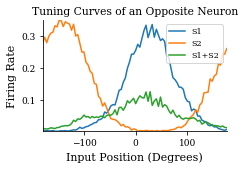

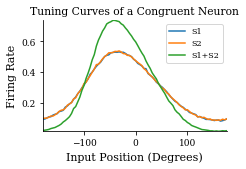

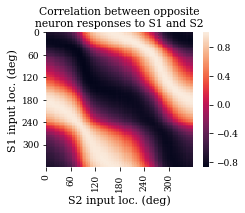

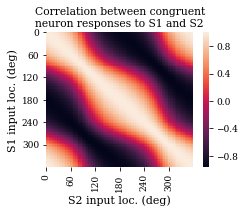

In [52]:
# Plot tuning curves and show that congruent and opposite neurons have congruent and opposite tunings.

N_int = int(N_stim/2)
x = np.linspace(-180.0, 180.0, num=N_int, endpoint=False)
i = 0
j = 0
set_style(box=False)
fig, axes = plt.subplots(1, 2, figsize=cplt.set_size("nips", fraction=1.2, ratio=0.4))
axes[1].set_title("Opposite neuron tuning curves")
axes[1].plot(x, tcs1_o[i], label="S1")
axes[1].plot(x, tcs2_o[i], label="S2")
axes[1].plot(x, tcs12_o[i], label="S1+S2")
axes[1].legend()
axes[0].set_title("Congruent neuron tuning curves")
axes[0].plot(x, tcs1_c[i], label="S1")
axes[0].plot(x, tcs2_c[i], label="S2")
axes[0].plot(x, tcs12_c[i], label="S1+S2")
axes[0].legend()
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Input Position (deg.)")
plt.ylabel("Firing Rate")
plt.tight_layout()
# cplt.savefig("Manuscript/Figures/Tuning_curves.pdf")
plt.show()

all_ro1, all_ro2 = tcs1_o.T, tcs2_o.T
corr = np.corrcoef(all_ro1, all_ro2)[:N_int,N_int:]
fig, axes = plt.subplots(1, 2, figsize=cplt.set_size("nips", fraction=1.2, ratio=0.5))
sns.heatmap(corr, ax=axes[1])
axes[1].set_xticks(np.arange(0, N_int, 15))
axes[1].set_xticklabels(np.arange(0, 360, 60))
axes[1].set_yticks(np.arange(0, N_int, 15))
axes[1].set_yticklabels(np.arange(0, 360, 60))
axes[1].set_title("Correlation between opposite\nneuron responses to S1 and S2")

all_rc1, all_rc2 = tcs1_c.T, tcs2_c.T
corr = np.corrcoef(all_rc1, all_rc2)[:N_int,N_int:]
sns.heatmap(corr, ax=axes[0])
axes[0].set_xticks(np.arange(0, N_int, 15))
axes[0].set_xticklabels(np.arange(0, 360, 60))
axes[0].set_yticks(np.arange(0, N_int, 15))
axes[0].set_yticklabels(np.arange(0, 360, 60))
axes[0].set_title("Correlation between congruent\nneuron responses to S1 and S2")

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("S2 input loc. (deg)", labelpad=10)
plt.ylabel("S1 input loc. (deg)")
plt.tight_layout()
# plt.savefig("Manuscript/Figures/Tuning_curves_correlation.png")
# cplt.savefig("Manuscript/Figures/Tuning_curves_correlation.pdf")
plt.show()

In [59]:
# Parameters
N = 180 # Number of neurons per module
a1_in = 1.5 # Input concentration of modality 1
a2_in = 1.5 # Input concentration of modality 2
a_rc = 3.0 # Recurrent connections concentration
omega = 1.6e-2
tau = 0.01 # time constant of leaky integrator
delta_t = 0.05 * tau # simulation timestep
tau_we = 10.0 # time constant of synaptic weight change of excitatory neurons
tau_wi = 10.0 # time constant of synaptic weight change of inhibitory neurons
tau_b = 5.0 # time constant of threshold change
delay = 0.02 # delay of signal from C to O
F = 0.5 # Fano factor, controls variance of firing rate
R1 = 1.0 # Maximum mean firing rate for modality 1
R2 = 1.0 # Maximum mean firing rate for modality 2
Ibc = -1.2
Ibo = 0.15
alpha = 15.0 # Controls strength of anti-hebbian connections, the larger the weaker.

thetas = np.linspace(-np.pi, np.pi, num=N, endpoint=False) # depends on N
delay_n = int(round(delay/delta_t)) # Number of timesteps to delay for

# Simulation length settings
T = 0.2 # simulation time
save_time = T # save simulation state every SAVE_TIME time.
n = int(round(T / delta_t)) # Number of timesteps # depends on T and delta_t
ts = np.linspace(0.0, T, num=n, endpoint=False) # depends on n
save_ts = np.linspace(0.0, T, num=int(T/save_time)+1) # depends on ts

# Convert stimulus location to firing rate
const = np.exp(-3.0)*i0(3.0)*2*np.pi
baseline = lambda R, a: (1-R) * const / (2*np.pi)
lamb = lambda s, R, a: lambda theta_j: R*const/(2*np.pi*i0(a))*np.exp(a*np.cos(s-theta_j)) + baseline(R, a)
r_in = lambda s, R, a: np.maximum(lamb(s,R,a)(thetas) + np.sqrt(F*lamb(s,R,a)(thetas))*np.random.normal(size=N), np.zeros(len(thetas)))

# Set up recurrent connections
rho = N/(2*np.pi)
J_crit2 = lambda a: np.sqrt(1/(rho*i0(a)) * 8*np.pi*omega*i0(a/2)**2)
W = lambda J, a: lambda theta1, theta2: J / (2*np.pi * i0(a)) * np.exp(a*np.cos(theta1 - theta2))
wro = W(0.5*J_crit2(a_rc), a_rc)(thetas, 0)
wrc = W(0.5*J_crit2(a_rc), a_rc)(thetas, 0)

reliability = [1.0, 0.75, 0.5, 0.25]
num = 9
s1_loc = np.linspace(-np.pi, np.pi, num=num, endpoint=False)
s2_loc = np.linspace(-np.pi, np.pi, num=num, endpoint=False)
results = np.zeros((len(reliability), num, num, 2, N))
for i in range(len(reliability)):
    for j in range(len(s1_loc)):
        for k in range(len(s2_loc)):
            r1_in = np.array([r_in(s1_loc[j], R1*reliability[i], a1_in) for _ in range(n)] + [np.zeros(N)])
            r2_in = np.array([r_in(s2_loc[k], R2, a2_in) for _ in range(n)] + [np.zeros(N)])
            
            # Initialize model
            w0 = np.concatenate((wc1f.flatten(), wc2f.flatten(), wo1f.flatten(), wo2f.flatten()))
            u0 = np.zeros(2*N)
            ubc0, ubo0 = ubcf, ubof
            y0 = np.concatenate((u0, w0, ubc0, ubo0))
            
            def dydt(t, y, i, all_rc):
                l, l2 = 2*N, -2*N
                u, w, ubs = y[:l], y[l:l2], y[l2:]
                l = N
                ubc, ubo = ubs[:l], ubs[l:]
                uc, uo = u[:l], u[l:]
                rc, ro = r(uc, uc, omega), r(uo, uo, omega)
                l = N*N
                wc1, wc2, wo1, wo2 = [np.reshape(w[j*l:(j+1)*l], (N,N)) for j in range(4)]
                j = max(i-delay_n, 0)
                dubcdt = np.zeros(N)
                dubodt = np.zeros(N)
                ducdt = 1/tau * (-uc + Ibc + convolve1d(rc, wrc, mode="wrap") + np.dot(wc1, r1_in[i]) + np.dot(wc2, r2_in[i]))
                duodt = 1/tau * (-uo + Ibo + convolve1d(ro, wro, mode="wrap") + np.dot(wo1, r1_in[i]) - np.dot(wo2, all_rc[j]))
                dwc1dt = np.zeros(N*N)
                dwc2dt = np.zeros(N*N)
                dwo1dt = np.zeros(N*N)
                dwo2dt = np.zeros(N*N)
                return np.concatenate((ducdt, duodt, dwc1dt.flatten(), dwc2dt.flatten(), dwo1dt.flatten(), dwo2dt.flatten(), dubcdt, dubodt))
            
            t, ys, r1_in_save, r2_in_save, all_rs = Newton(dydt, y0, ts, save_ts, progress=False)
            all_rc, all_ro = all_rs
#             plt.plot(ts, all_ro[1:,0])
#             plt.show()
            results[i][j][k][0] = all_rc[-1]
            results[i][j][k][1] = all_ro[-1]

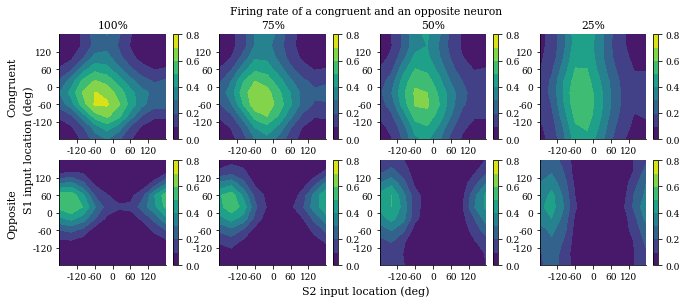

In [61]:
def wrap(res):
    x0 = np.array([res[0]])
    new_res = np.append(res, x0, axis=0)
    y0 = np.array([new_res[:,0]]).T
    new_res = np.append(new_res, y0, axis=1)
    return new_res

neuron = 0
fig, axes = plt.subplots(2,4,figsize=(cplt.set_size("nips")[0]*2, cplt.set_size("nips")[1]*1.25))
x = np.linspace(-180.0, 180.0, num=len(s1_loc)+1)
y = np.linspace(-180.0, 180.0, num=len(s2_loc)+1)
levels = np.linspace(0.0, 0.8, num=9)
titles = ["100%", "75%", "50%", "25%"]
ticks = [-120, -60, 0, 60, 120]
for i in range(len(reliability)):
    c0 = axes[0][i].contourf(y, x, wrap(results[i,:,:,0,neuron]), levels, cmap="viridis")
    c1 = axes[1][i].contourf(y, x, wrap(results[i,:,:,1,neuron]), levels, cmap="viridis")
    fig.colorbar(c0, ax=axes[0][i], ticks=[0.0, 0.2, 0.4, 0.6, 0.8])
    fig.colorbar(c1, ax=axes[1][i], ticks=[0.0, 0.2, 0.4, 0.6, 0.8])
    axes[0][i].set_title(titles[i])
    axes[0][i].set_xticks(ticks)
    axes[0][i].set_xticklabels(ticks)
    axes[0][i].set_yticks(ticks)
    axes[0][i].set_yticklabels(ticks)
    axes[1][i].set_xticks(ticks)
    axes[1][i].set_xticklabels(ticks)
    axes[1][i].set_yticks(ticks)
    axes[1][i].set_yticklabels(ticks)

axes[0][0].set_ylabel("Congruent", labelpad=15)
axes[1][0].set_ylabel("Opposite", labelpad=15)
fig.add_subplot(111, frameon=False)
plt.title("Firing rate of a congruent and an opposite neuron", pad=20)
# plt.colorbar(c0)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("S2 input location (deg)")
plt.ylabel("S1 input location (deg)")
# cplt.savefig("Manuscript/Figures/Bimodal_reliability.pdf")
plt.show()

In [62]:
# Parameters
N = 180 # Number of neurons per module
a1_in = 1.5 # Input concentration of modality 1
a2_in = 1.5 # Input concentration of modality 2
a_rc = 3.0 # Recurrent connections concentration
omega = 1.6e-2
tau = 0.01 # time constant of leaky integrator
delta_t = 0.05 * tau # simulation timestep
tau_we = 10.0 # time constant of synaptic weight change of excitatory neurons
tau_wi = 10.0 # time constant of synaptic weight change of inhibitory neurons
tau_b = 5.0 # time constant of threshold change
delay = 0.02 # delay of signal from C to O
F = 0.5 # Fano factor, controls variance of firing rate
R1 = 1.0 # Maximum mean firing rate for modality 1
R2 = 1.0 # Maximum mean firing rate for modality 2
Ibc = -1.2
Ibo = 0.15
alpha = 15.0 # Controls strength of anti-hebbian connections, the larger the weaker.

thetas = np.linspace(-np.pi, np.pi, num=N, endpoint=False) # depends on N
delay_n = int(round(delay/delta_t)) # Number of timesteps to delay for

# Simulation length settings
T = 0.2 # simulation time
save_time = T # save simulation state every SAVE_TIME time.
n = int(round(T / delta_t)) # Number of timesteps # depends on T and delta_t
ts = np.linspace(0.0, T, num=n, endpoint=False) # depends on n
save_ts = np.linspace(0.0, T, num=int(T/save_time)+1) # depends on ts

# Convert stimulus location to firing rate
const = np.exp(-3.0)*i0(3.0)*2*np.pi
baseline = lambda R, a: (1-R) * const / (2*np.pi)
lamb = lambda s, R, a: lambda theta_j: R*const/(2*np.pi*i0(a))*np.exp(a*np.cos(s-theta_j)) + baseline(R, a)
r_in = lambda s, R, a: np.maximum(lamb(s,R,a)(thetas) + np.sqrt(F*lamb(s,R,a)(thetas))*np.random.normal(size=N), np.zeros(len(thetas)))

# Set up recurrent connections
rho = N/(2*np.pi)
J_crit2 = lambda a: np.sqrt(1/(rho*i0(a)) * 8*np.pi*omega*i0(a/2)**2)
W = lambda J, a: lambda theta1, theta2: J / (2*np.pi * i0(a)) * np.exp(a*np.cos(theta1 - theta2))
wro = W(0.5*J_crit2(a_rc), a_rc)(thetas, 0)
wrc = W(0.5*J_crit2(a_rc), a_rc)(thetas, 0)

reliability = [1.0,0.8,0.6,0.4,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
reliability2 = [0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.8,0.6,0.4,0.2,0.0]
num = 20
s1_loc = np.linspace(-np.pi, np.pi, num=num, endpoint=False)
results = np.zeros((len(reliability), num, 2, N))
for i in range(len(reliability)):
    for j in range(len(s1_loc)):
        r1_in = np.array([r_in(s1_loc[j], R1*reliability[i], a1_in) for _ in range(n)] + [np.zeros(N)])
        r2_in = np.array([r_in(s1_loc[j], R2*reliability2[i], a2_in) for _ in range(n)] + [np.zeros(N)])

        # Initialize model
        w0 = np.concatenate((wc1f.flatten(), wc2f.flatten(), wo1f.flatten(), wo2f.flatten()))
        u0 = np.zeros(2*N)
        ubc0, ubo0 = ubcf, ubof
        y0 = np.concatenate((u0, w0, ubc0, ubo0))

        def dydt(t, y, i, all_rc):
            l, l2 = 2*N, -2*N
            u, w, ubs = y[:l], y[l:l2], y[l2:]
            l = N
            ubc, ubo = ubs[:l], ubs[l:]
            uc, uo = u[:l], u[l:]
            rc, ro = r(uc, uc, omega), r(uo, uo, omega)
            l = N*N
            wc1, wc2, wo1, wo2 = [np.reshape(w[j*l:(j+1)*l], (N,N)) for j in range(4)]
            j = max(i-delay_n, 0)
            dubcdt = np.zeros(N)
            dubodt = np.zeros(N)
            ducdt = 1/tau * (-uc + Ibc + convolve1d(rc, wrc, mode="wrap") + np.dot(wc1, r1_in[i]) + np.dot(wc2, r2_in[i]))
            duodt = 1/tau * (-uo + Ibo + convolve1d(ro, wro, mode="wrap") + np.dot(wo1, r1_in[i]) - np.dot(wo2, all_rc[j]))
            dwc1dt = np.zeros(N*N)
            dwc2dt = np.zeros(N*N)
            dwo1dt = np.zeros(N*N)
            dwo2dt = np.zeros(N*N)
            return np.concatenate((ducdt, duodt, dwc1dt.flatten(), dwc2dt.flatten(), dwo1dt.flatten(), dwo2dt.flatten(), dubcdt, dubodt))

        t, ys, r1_in_save, r2_in_save, all_rs = Newton(dydt, y0, ts, save_ts, progress=False)
        all_rc, all_ro = all_rs
#             plt.plot(ts, all_ro[1:,0])
#             plt.show()
        results[i][j][0] = all_rc[-1]
        results[i][j][1] = all_ro[-1]

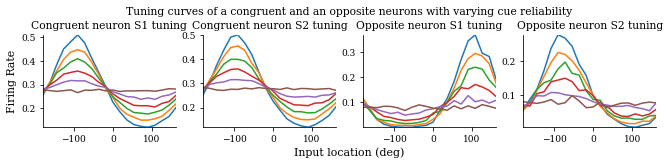

In [64]:
neuron = 155
set_style(ymargin=0.0)
fig, axes = plt.subplots(1,4,figsize=(cplt.set_size("nips")[0]*2, cplt.set_size("nips")[1]*0.5))
x = np.linspace(-180.0, 180.0, num=len(s1_loc), endpoint=False)
k = int(len(reliability)/2)
titles = ["Congruent neuron S1 tuning", "Congruent neuron S2 tuning", "Opposite neuron S1 tuning", "Opposite neuron S2 tuning"]
for i in range(k):
    axes[0].plot(x, results[i,:,0,neuron], label=str(reliability[i]))
    axes[2].plot(x, results[i,:,1,neuron], label=str(reliability[i]))
for i in range(k, k*2):
    axes[1].plot(x, results[i,:,0,neuron], label=str(reliability2[i]))
    axes[3].plot(x, results[i,:,1,neuron], label=str(reliability2[i]))
# plt.legend()
for i in range(4):
    axes[i].set_title(titles[i])
fig.add_subplot(111, frameon=False)
plt.title("Tuning curves of a congruent and an opposite neurons with varying cue reliability", pad=20)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Input location (deg)")
plt.ylabel("Firing Rate")
# cplt.savefig("Manuscript/Figures/Unimodal_reliability.pdf")
plt.show()